In [4]:
from PIL import Image
from IPython.display import Image as DPImage
import os
import numpy as np
from random import sample
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sk
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import random
import csv
import skimage

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import Input

seed = 2023
np.random.seed(seed)  

# Useful Functions

In [5]:
def display_img(image, title=''):
    plt.title(title)
    plt.imshow(tf.keras.utils.array_to_img(image))
    plt.axis('off')
    plt.show()

def plot_history(history, steps_per_epoch = 0, y_axis_lower_bound = -1):
    
    if steps_per_epoch >0:
        xvals = int(steps_per_epoch)*np.array(history.epoch)
        xlab = 'Weight update steps'
    else:
        xvals = np.array(history.epoch)
        xlab = 'Epochs'


    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    plt.xlabel(xlab)
    plt.ylabel('Accuracy')
    plt.plot(xvals, np.array(history.history['accuracy']),'g-', 
             label='Train accuracy')
    plt.plot(xvals, np.array(history.history['val_accuracy']),'r-',
             label = 'Validation accuracy')
    if y_axis_lower_bound>-1:
        plt.ylim([y_axis_lower_bound,1])
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel(xlab)
    plt.ylabel('Loss minimised by model')
    plt.plot(xvals, np.array(history.history['loss']),'g-', 
             label='Train loss')
    plt.plot(xvals, np.array(history.history['val_loss']),'r-',
             label = 'Validation loss')
    plt.legend()

# Load + Pre-Process Data

#### 1) Resizing
The process is one of the options that is resizing images to a fixed size (128, 128).

In [6]:
def readAndResizeImages(data_dir, with_labels=True):
    height = 128
    width = 128
    image_ids = os.listdir(data_dir)
    X = np.zeros((len(image_ids), height, width, 3), dtype=np.uint8)
    Y = np.zeros((len(image_ids), height, width, 1), dtype=np.bool_)
    for i in range(len(image_ids)):
        sample = {}

        path_images = f"{data_dir}/{image_ids[i]}/images"
        filename_image = os.listdir(path_images)[0]
        image = tf.keras.utils.load_img(f"{path_images}/{filename_image}")
        image = tf.image.resize(image, [height, width])
        X[i] = image
        
        if with_labels:
            path_mask = f"{data_dir}/{image_ids[i]}/combined_masks"
            filename_mask = os.listdir(path_mask)[0]
            mask = tf.keras.utils.load_img(f"{path_mask}/{filename_mask}")
            mask = tf.image.resize(mask, [height, width], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)[:,:,:1]
            Y[i] = mask
    
    return X, Y, image_ids

In [8]:
X_train, Y_train, imageIDs_train = readAndResizeImages("./data/stage1_train")
X_val, Y_val, imageIDs_val = readAndResizeImages("./data/stage1_test")
X_test, _, imageIDs_test = readAndResizeImages("./data/stage2_test_final", with_labels=False)

The image id is 8a26b134fe9343c0c794513dae7787b7ac1debec3bb2a7096ab0b874a31d8175, the dimension of the image is (256, 256) (width x height).
The original image


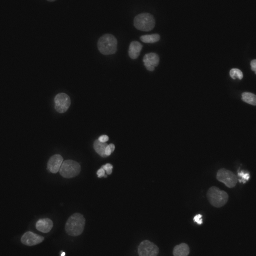

The original mask


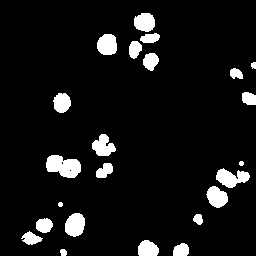

The image after resizing


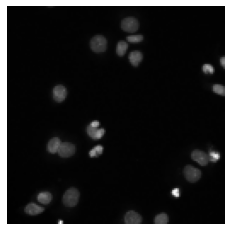

The mask after resizing


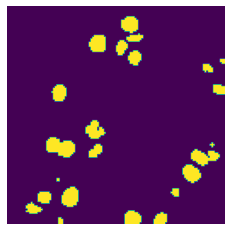

In [9]:
idx = 2
img_size = Image.open(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png").size
print(f"The image id is {imageIDs_train[idx]}, the dimension of the image is {img_size} (width x height).")
print('The original image')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png"))

print('The original mask')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/combined_masks/{imageIDs_train[idx]}.png"))
print('The image after resizing')
display_img(X_train[idx])
print('The mask after resizing')
display_img(Y_train[idx])

#### 2) Resizing with padding
The process is one of the options that is padding images to a fixed size (256, 256). Resizes an image to a target width and height by keeping the aspect ratio the same without distortion. If the target dimensions don't match the image dimensions, the image is resized and then padded with zeroes to match requested dimensions.

In [48]:
def readAndresizepadImages(data_dir, with_labels=True):
    height = 256
    width = 256
    image_ids = os.listdir(data_dir)
    X = np.zeros((len(image_ids), height, width, 3), dtype=np.uint8)
    Y = np.zeros((len(image_ids), height, width, 1), dtype=np.bool_)
    for i in range(len(image_ids)):
        sample = {}

        path_images = f"{data_dir}/{image_ids[i]}/images"
        filename_image = os.listdir(path_images)[0]
        image = tf.keras.utils.load_img(f"{path_images}/{filename_image}")
        image = tf.image.resize_with_pad(image, height, width)
        X[i] = image
        
        if with_labels:
            path_mask = f"{data_dir}/{image_ids[i]}/combined_masks"
            filename_mask = os.listdir(path_mask)[0]
            mask = tf.keras.utils.load_img(f"{path_mask}/{filename_mask}")
            mask = tf.image.resize_with_pad(mask, height, width, method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)[:,:,:1]
            Y[i] = mask
    
    return X, Y, image_ids

In [77]:
X_train, Y_train, imageIDs_train = readAndresizepadImages("./data/stage1_train")
X_val, Y_val, imageIDs_val = readAndresizepadImages("./data/stage1_test")
X_test, _, imageIDs_test = readAndresizepadImages("./data/stage2_test_final", with_labels=False)

The image id is 00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e, the dimension of the image is (320, 256).
The original image


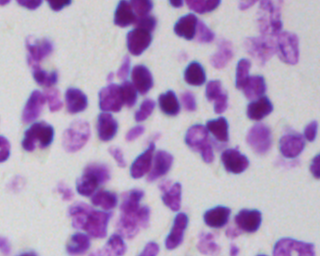

The original mask


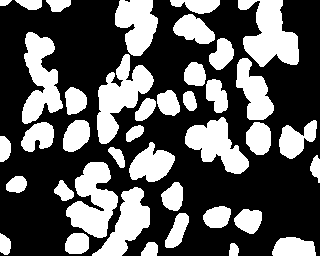

The image after resizing


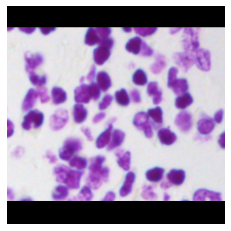

The mask after resizing


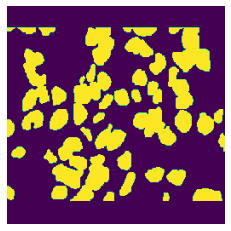

In [80]:
idx = 2
img_size = Image.open(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png").size
print(f"The image id is {imageIDs_train[idx]}, the dimension of the image is {img_size} (width x height).")
print('The original image')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png"))

print('The original mask')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/combined_masks/{imageIDs_train[idx]}.png"))
print('The image after resizing')
display_img(X_train[idx])
print('The mask after resizing')
display_img(Y_train[idx])

#### 3) Ramdom cropping
Randomly crops a tensor to a given size.

In [90]:
def readAndramdomcropImages(data_dir, crop_times, with_labels=True):
    height = 128
    width = 128
    image_ids = os.listdir(data_dir)
    X = np.zeros((len(image_ids* crop_times), height, width, 3), dtype=np.uint8)
    Y = np.zeros((len(image_ids* crop_times), height, width, 1), dtype=np.bool_)
    for i in range(len(image_ids) * crop_times):
        sample = {}

        path_images = f"{data_dir}/{image_ids[i//crop_times]}/images"
        filename_image = os.listdir(path_images)[0]
        image = tf.keras.utils.load_img(f"{path_images}/{filename_image}")
        image = tf.image.random_crop(image, [height, width, 3])
        X[i] = image
        
        if with_labels:
            path_mask = f"{data_dir}/{image_ids[i//crop_times]}/combined_masks"
            filename_mask = os.listdir(path_mask)[0]
            mask = tf.keras.utils.load_img(f"{path_mask}/{filename_mask}")
            mask = tf.image.random_crop(mask, [height, width, 3])[:,:,:1]
            Y[i] = mask
    
    return X, Y, image_ids

In [91]:
X_train, Y_train, imageIDs_train = readAndramdomcropImages("./data/stage1_train", 5)
X_val, Y_val, imageIDs_val = readAndramdomcropImages("./data/stage1_test", 5)
X_test, _, imageIDs_test = readAndramdomcropImages("./data/stage2_test_final", 5, with_labels=False)

The image id is 00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e, the dimension of the image is (320, 256).
The original image


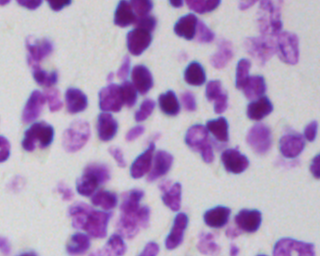

The original mask


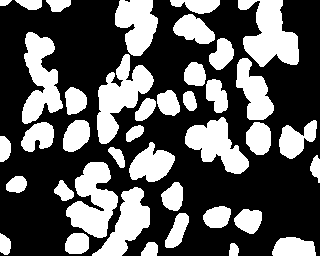

The image after resizing


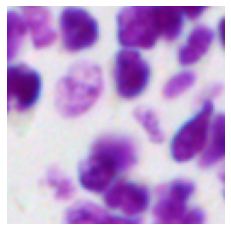

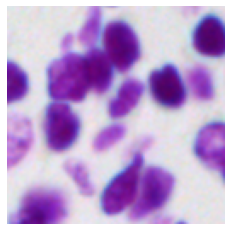

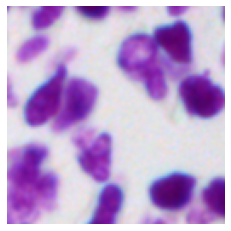

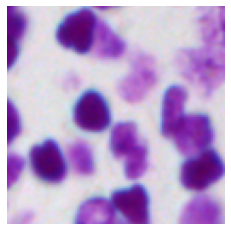

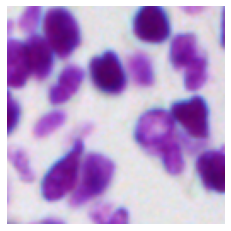

The mask after resizing


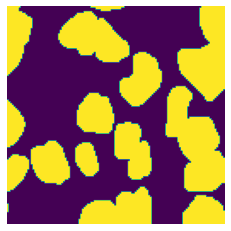

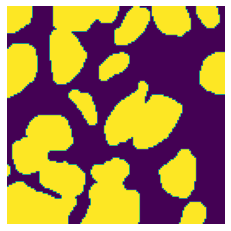

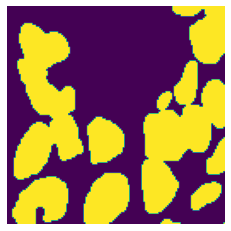

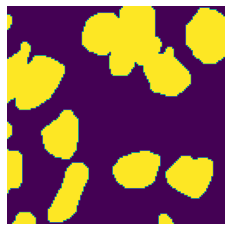

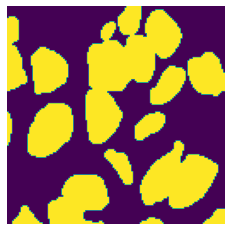

In [93]:
idx = 2
img_size = Image.open(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png").size
print(f"The image id is {imageIDs_train[idx]}, the dimension of the image is {img_size} (width x height).")
print('The original image')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png"))

print('The original mask')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/combined_masks/{imageIDs_train[idx]}.png"))
print('The image after resizing')
for idx1 in range(idx*5,idx*5+5):
    display_img(X_train[idx1])
print('The mask after resizing')
for idx1 in range(idx*5,idx*5+5):
    display_img(Y_train[idx1])

#### 4) Padding
Pad image with zeros to the specified height and width.

In [146]:
def readAndpadImages(data_dir, with_labels=True):
    height = 1040
    width = 1388
    image_ids = os.listdir(data_dir)
    X = np.zeros((len(image_ids), height, width, 3), dtype=np.uint8)
    Y = np.zeros((len(image_ids), height, width, 1), dtype=np.bool_)
    for i in range(len(image_ids)):
        sample = {}

        path_images = f"{data_dir}/{image_ids[i]}/images"
        filename_image = os.listdir(path_images)[0]
        image = tf.keras.utils.load_img(f"{path_images}/{filename_image}")
        offset_height = (height - image.size[1])//2
        offset_width = (width - image.size[0])//2
        image = tf.image.pad_to_bounding_box(image, offset_height, offset_width, height, width)
        X[i] = image
        if with_labels:
            path_mask = f"{data_dir}/{image_ids[i]}/combined_masks"
            filename_mask = os.listdir(path_mask)[0]
            mask = tf.keras.utils.load_img(f"{path_mask}/{filename_mask}")
            mask = tf.image.pad_to_bounding_box(mask, offset_height, offset_width, height, width)[:,:,:1]
            Y[i] = mask
    
    return X, Y, image_ids

In [147]:
X_train, Y_train, imageIDs_train = readAndpadImages("./data/stage1_train")
X_val, Y_val, imageIDs_val = readAndpadImages("./data/stage1_test")
X_test, _, imageIDs_test = readAndpadImages("./data/stage2_test_final", with_labels=False)

The image id is 00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e, the dimension of the image is (320, 256) (width x height).
The original image


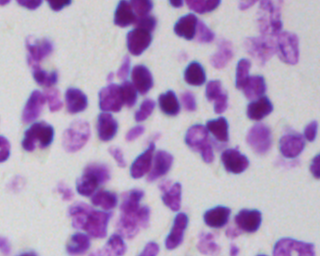

The original mask


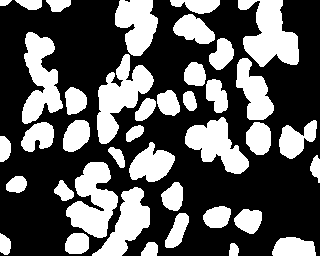

The image after resizing


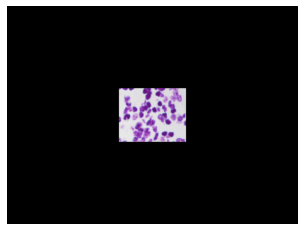

The mask after resizing


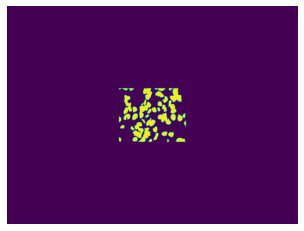

In [148]:
idx = 2
img_size = Image.open(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png").size
print(f"The image id is {imageIDs_train[idx]}, the dimension of the image is {img_size} (width x height).")
print('The original image')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png"))

print('The original mask')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/combined_masks/{imageIDs_train[idx]}.png"))
print('The image after resizing')
display_img(X_train[idx])
print('The mask after resizing')
display_img(Y_train[idx])

#### 5) Padding + cropping
first perform the padding processing to ensure the height and width is equal or above the design cropping size. In this case, the cropping size could be slightly higher without the contraint of minimal dimension of imagines of these three sets.

In [164]:
def readAndcroppadImages(data_dir, with_labels=True):
    height = 256
    width = 256
    image_ids = os.listdir(data_dir)
    X = np.zeros((len(image_ids), height, width, 3), dtype=np.uint8)
    Y = np.zeros((len(image_ids), height, width, 1), dtype=np.bool_)
    for i in range(len(image_ids)):
        sample = {}

        path_images = f"{data_dir}/{image_ids[i]}/images"
        filename_image = os.listdir(path_images)[0]
        image = tf.keras.utils.load_img(f"{path_images}/{filename_image}")

        offset_height = (height - image.size[1])//2
        height0 = height
        width0 = width
        if offset_height < 0:
            height0 = image.size[1]
            offset_height = 0
        offset_width = (width - image.size[0])//2
        if offset_width < 0:
            width0 = image.size[0]
            offset_width = 0
        image = tf.image.pad_to_bounding_box(image, offset_height, offset_width, height0, width0)
        image = tf.image.random_crop(image, [height, width, 3])

        X[i] = image
        if with_labels:
            path_mask = f"{data_dir}/{image_ids[i]}/combined_masks"
            filename_mask = os.listdir(path_mask)[0]
            mask = tf.keras.utils.load_img(f"{path_mask}/{filename_mask}")
            mask = tf.image.pad_to_bounding_box(mask, offset_height, offset_width, height0, width0)[:,:,:1]
            mask = tf.image.random_crop(mask, [height, width, 1])
            Y[i] = mask
    
    return X, Y, image_ids

In [165]:
X_train, Y_train, imageIDs_train = readAndcroppadImages("./data/stage1_train")
X_val, Y_val, imageIDs_val = readAndcroppadImages("./data/stage1_test")
X_test, _, imageIDs_test = readAndcroppadImages("./data/stage2_test_final", with_labels=False)

The image id is 00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e, the dimension of the image is (320, 256) (width x height).
The original image


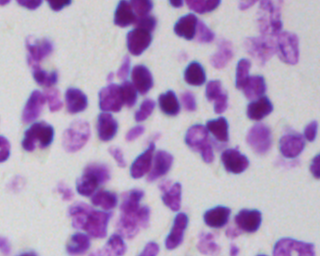

The original mask


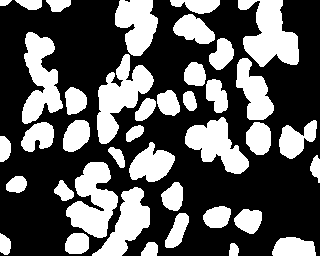

The image after resizing


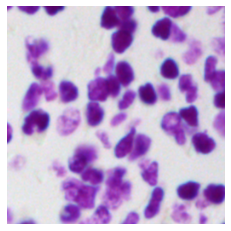

The mask after resizing


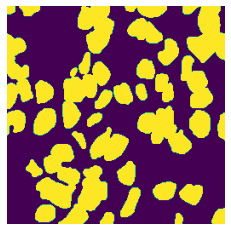

In [166]:
idx = 2
img_size = Image.open(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png").size
print(f"The image id is {imageIDs_train[idx]}, the dimension of the image is {img_size} (width x height).")
print('The original image')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png"))

print('The original mask')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/combined_masks/{imageIDs_train[idx]}.png"))
print('The image after resizing')
display_img(X_train[idx])
print('The mask after resizing')
display_img(Y_train[idx])

# Train Model

In [10]:
# The convolation block 
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x


# The encoder block
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling2D((2, 2))(x)
    
    return x, p


# The decoder block
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)

    return x

In [22]:
def create_model(input_shape, LR):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=Adam(), #learning_rate=LR
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model

In [12]:
batch_size = 16
batches_per_epoch = int(len(X_train)/batch_size) 
epochs = 25
LR = 0.0001
stopping_patience = 10
stopping_delta = 0.001

model = create_model((128, 128, 3), LR)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [13]:
stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                     patience=stopping_patience, 
                                                     min_delta=stopping_delta,
                                                     verbose = 1,
                                                     restore_best_weights=True)

results = model.fit(X_train, Y_train, 
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,  
                    validation_data=(X_val, Y_val),
                    callbacks = [stopping_callback],
                    shuffle=True)

Epoch 1/25


2023-05-01 12:05:46.460970: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


42/42 [==============================] - 35s 117ms/step - loss: 0.3114 - accuracy: 0.8945 - val_loss: 14.2663 - val_accuracy: 0.2127
Epoch 2/25
42/42 [==============================] - 3s 77ms/step - loss: 0.1475 - accuracy: 0.9554 - val_loss: 0.2609 - val_accuracy: 0.9264
Epoch 3/25
42/42 [==============================] - 3s 75ms/step - loss: 0.1121 - accuracy: 0.9646 - val_loss: 0.2140 - val_accuracy: 0.9240
Epoch 4/25
42/42 [==============================] - 3s 75ms/step - loss: 0.1044 - accuracy: 0.9657 - val_loss: 2.9466 - val_accuracy: 0.3684
Epoch 5/25
42/42 [==============================] - 3s 75ms/step - loss: 0.0893 - accuracy: 0.9693 - val_loss: 0.7148 - val_accuracy: 0.6655
Epoch 6/25
42/42 [==============================] - 3s 77ms/step - loss: 0.0853 - accuracy: 0.9699 - val_loss: 0.1680 - val_accuracy: 0.9370
Epoch 7/25
42/42 [==============================] - 3s 76ms/step - loss: 0.0795 - accuracy: 0.9713 - val_loss: 0.1795 - val_accuracy: 0.9333
Epoch 8/25
42/42 [===

Training set Accuracy: 0.9696
Training set Loss:0.097272

Validation set Accuracy: 0.9370
Validation set Loss:0.168029



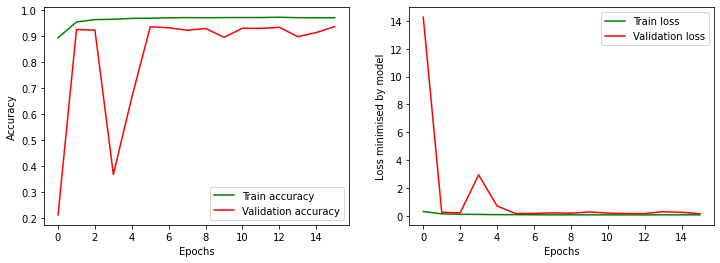

In [14]:
[train_loss, train_accuracy] = model.evaluate(X_train, Y_train, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[val_loss, val_accuracy] = model.evaluate(X_val, Y_val, verbose=0)
print("Validation set Accuracy:{:7.4f}".format(val_accuracy))
print("Validation set Loss:{:7.6f}\n".format(val_loss))

plot_history(results)

## Testing

In [15]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_val, verbose=1)
preds_test = model.predict(X_test, verbose=1)

95/95 [==============================] - 4s 43ms/step


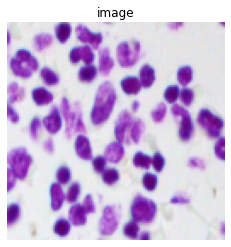

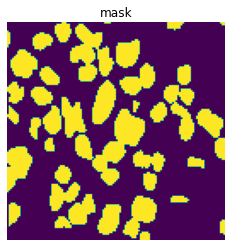

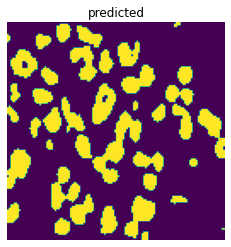

In [21]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

ix = random.randint(0, len(preds_val_t))
ix = 300
display_img(X_train[ix], title="image")
display_img(Y_train[ix], title="mask")
display_img(preds_train_t[ix], title="predicted")

In [13]:
ix

78

## Export Predicted masks to CSV

In [15]:
testset_predictions = (preds_test > 0.5).astype(np.uint8)

In [56]:
template_csv = "./data/stage2_sample_submission_final.csv"
image_dir = "./data/stage2_test_final"
output_csv = "submission_test.csv"

show_no_nuclei_images = False

print(f"Saving {testset_predictions.shape[0]} predictions")
with open(output_csv, 'w', newline='') as output_csvfile:
    writer = csv.DictWriter(output_csvfile, fieldnames=["ImageId", "EncodedPixels"])
    writer.writeheader()
    total_nucleus_count = 0
    
    progress_indices = np.linspace(0, testset_predictions.shape[0], 21, dtype=int)
    
    with open(template_csv, newline='') as template_csvfile:
        for i, (imgID, _) in enumerate(csv.reader(template_csvfile, delimiter=',')):
            if i == 0: # Skip row with labels
                continue

            # Get Prediction For ImgID
            prediction = testset_predictions[imageIDs_test.index(imgID)]

            # Scale Predicted Mask Back To Original Image Size
            original_image_size = Image.open(f"{image_dir}/{imgID}/images/{os.listdir(f'{image_dir}/{imgID}/images')[0]}").size
            predicted_mask = tf.keras.utils.img_to_array(
                tf.image.resize(prediction, original_image_size, method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            )[:, :, 0]
            
            predicted_mask_T = predicted_mask.transpose()
            
            # Label each nucleus in mask
            (labeled_mask, nucleus_amount) = skimage.measure.label(predicted_mask_T, connectivity=2, background=0, return_num=True)
            total_nucleus_count += nucleus_amount
            if nucleus_amount == 0 and show_no_nuclei_images:
                print(f"No nuclei found for image {imgID}")
                try:
                    display_img(Image.open(f"{image_dir}/{imgID}/images/{os.listdir(f'{image_dir}/{imgID}/images')[0]}"))
                except:
                    print(f"Error while displaying image {imgID}")
            
            # Calculate RLE
            RLE = [[] for _ in range(nucleus_amount)]
            curr_pixel = 1
            run_length = 0
            run_label = 0
            
            for i_c, c in enumerate(labeled_mask):
                for i_r, x in enumerate(c):
                    if x:
                        if run_length == 0 or run_label != x:
                            if run_length > 0:
                                RLE[run_label-1].append(run_length)
                                run_length = 0
                            RLE[x-1].append(i_c * labeled_mask.shape[1] + i_r + 1)
                            run_label = x
                        run_length += 1
                    elif run_length > 0:
                        RLE[run_label-1].append(run_length)
                        run_length = 0
                        run_label = 0
            if run_length > 0:
                RLE[run_label-1].append(run_length)
            
            # Write To output file
            for nucleus_RLE in RLE:
                writer.writerow({"ImageId": imgID, "EncodedPixels": ' '.join(map(str, nucleus_RLE))})
            
            if nucleus_amount == 0: # default entry
                writer.writerow({"ImageId": imgID, "EncodedPixels": ''})
            
            # Show sign of progress
            if i in progress_indices:
                print(f"{np.where(progress_indices == i)[0][0] * 5}%")
    
    print()
    print(f"Found {total_nucleus_count} nuclei in {testset_predictions.shape[0]} images")

Saving 3019 predictions
5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
55%
60%
65%
70%
75%
80%
85%
90%
95%
100%

Found 72769 nuclei in 3019 images


#### Architectures to try out 

Attention U-net

Residual U-Net

Mask R-CNN

Basic Unet + ResNet encoder